In [1]:
import sys
import os
import tensorflow as tf
import numpy as np
from utils import *
import matplotlib.pyplot as plt
from datetime import datetime

from utils import *
from equations import *

In [2]:
epochADAM = 200000
epochLBFGS = 100000
N_u=500
N_f=1000
seed=1234
log_frequency=10000
history_frequency=10
NLayers=6
NNeurons=10
noiseLevel=[]
# vel, (h,H), C, FSSA, (FH, SMB), BC
weights = [5,3,5,6,0,14]

In [3]:
hp = {}
# Data size on the solution u
hp["N_u"] = N_u
# Collocation points size, where we’ll check for f = 0
hp["N_f"] = N_f
# DeepNN topology (2-sized input [x,t], NLayers hidden layer of NNeurons-width, 1-sized output [u]
hp["layers"] = [2]+[NNeurons]*NLayers+[1]
# DeepNN topology (2-sized input [x,t], NLayers hidden layer of NNeurons-width, 2-sized output [h, H]
hp["h_layers"] = [2]+[NNeurons]*NLayers+[2]
# DeepNN topology (1-sized input [x], NLayers hidden layer of NNeurons-width, 1-sized output [C]
hp["C_layers"] = [1]+[NNeurons]*NLayers+[1]
# DeepNN topology (2-sized input [x,t], NLayers hidden layer of NNeurons-width, 1-sized output [SMB]
hp["smb_layers"] = [2]+[NNeurons]*NLayers+[1]

# Setting up the TF SGD-based optimizer (set tf_epochs=0 to cancel it)
hp["tf_epochs"] = epochADAM
hp["tf_lr"] = 0.001
hp["tf_b1"] = 0.99
hp["tf_eps"] = 1e-1
# Setting up the quasi-newton LBGFS optimizer (set nt_epochs=0 to cancel it)
hp["nt_epochs"] = epochLBFGS
hp["log_frequency"] = log_frequency
# Record the history
hp["save_history"] = True
hp["history_frequency"] = history_frequency
# path for loading data and saving models
repoPath = "./"
appDataPath = os.path.join(repoPath, "matlab_SSA", "DATA")
path = os.path.join(appDataPath, "Helheim_Big_Rignot_SMW_Schoof_PINN_flowline_transient_recomputeC.mat")

loss_weights = [10**(-w) for w in weights]

now = datetime.now()

modelPath = "./Models/SSA1D_transient_"+str(NLayers)+"x"+str(NNeurons)+"_weights"+ "".join([str(w)+"_" for w in weights]) + now.strftime("%Y%m%d_%H%M%S")

modelPath += ("_seed_" + str(seed) if seed else "")
# + "ADAM"+str(hp["tf_epochs"]) +"_BFGS"+str(hp["nt_epochs"])
reloadModel = False # reload from previous training

In [4]:
X_star, u_star, X_train, u_train, X_1d, C_1d, X_f, X_bc, u_bc, X_cf, n_cf, xub, xlb, uub, ulb, mu = prep_Helheim_transient(path=path, N_u=N_u, N_f=N_f)

In [5]:
logger = Logger(hp)
pinn = SSA1D_transient(hp, logger, X_f,
        X_bc, u_bc,
        X_cf, n_cf,
        xub, xlb, uub, ulb,
        modelPath, reloadModel,
        mu=mu,
        loss_weights=loss_weights)

Hyperparameters:
{
  "N_u": 500,
  "N_f": 1000,
  "layers": [
    2,
    10,
    10,
    10,
    10,
    10,
    10,
    1
  ],
  "h_layers": [
    2,
    10,
    10,
    10,
    10,
    10,
    10,
    2
  ],
  "C_layers": [
    1,
    10,
    10,
    10,
    10,
    10,
    10,
    1
  ],
  "smb_layers": [
    2,
    10,
    10,
    10,
    10,
    10,
    10,
    1
  ],
  "tf_epochs": 200000,
  "tf_lr": 0.001,
  "tf_b1": 0.99,
  "tf_eps": 0.1,
  "nt_epochs": 100000,
  "log_frequency": 10000,
  "save_history": true,
  "history_frequency": 10
}

TensorFlow version: 2.4.1
Eager execution: True
GPU-accerelated: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
# error function for logger
X_u = pinn.tensor(X_1d)
u = pinn.tensor(C_1d)
def error():
    return pinn.test_error(X_u, u)
logger.set_error_fn(error)

In [7]:
pinn.fit(X_train, u_train)


Training started
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
minmax_scale_layer (MinmaxSc (None, 2)                 6         
_________________________________________________________________
dense (Dense)                (None, 10)                30        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_5 (Dense)              (None, 10

In [8]:
pinn.save()

INFO:tensorflow:Assets written to: ./Models/SSA1D_transient_6x10_weights5_3_5_6_0_14_20231031_183430_seed_1234/assets


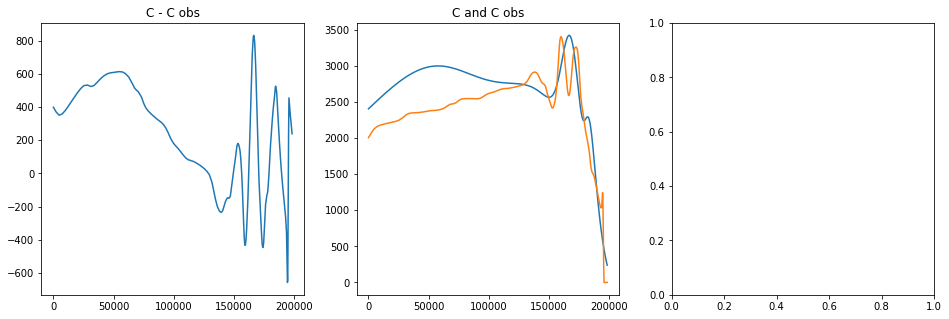

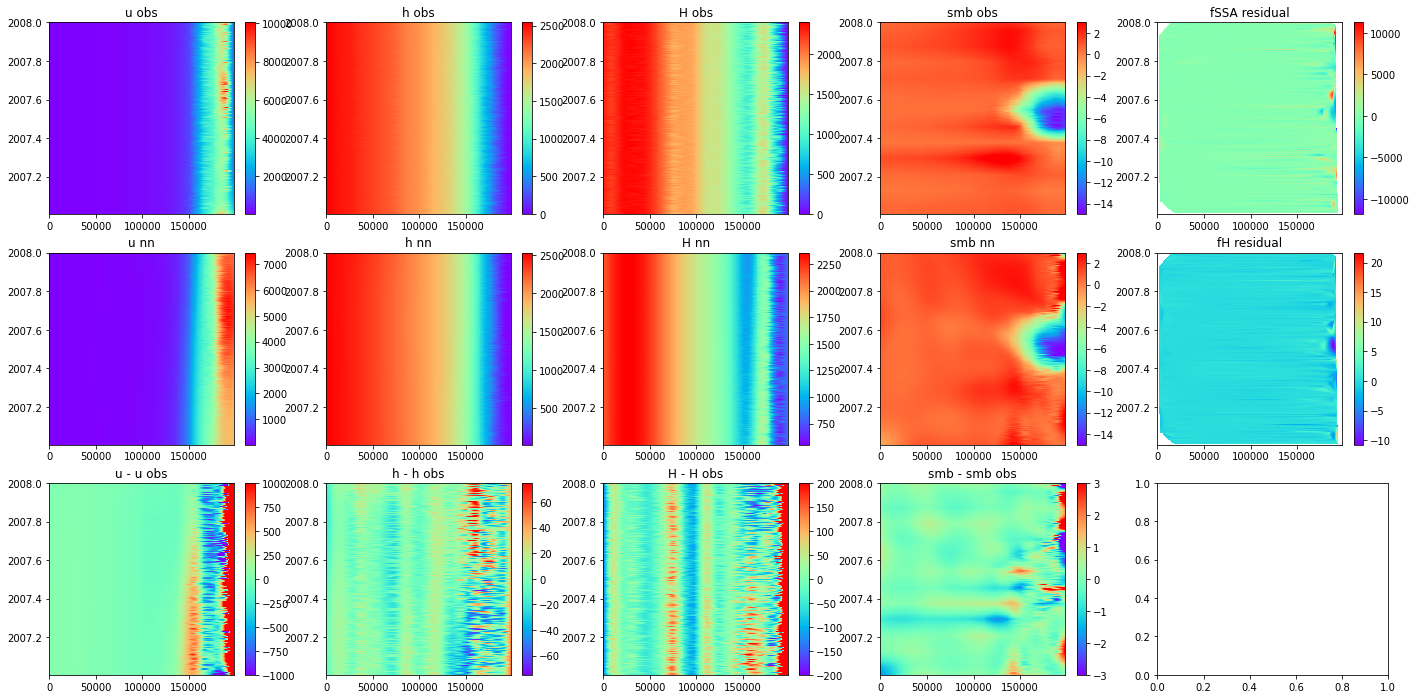

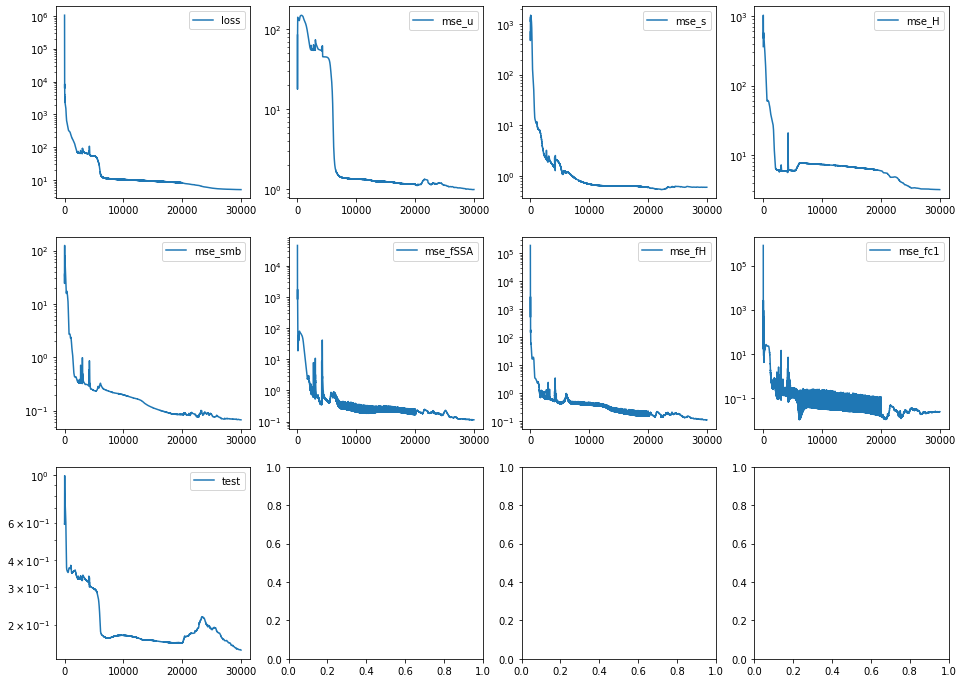

In [10]:
# plot
plot_1D_transient_solutions(pinn, X_f, X_star, u_star, X_1d, C_1d, xlb, xub, 
                            vranges={'smb nn': [-15,3], 'smb obs': [-15,3], 'u - u obs':[-1e3,1e3], 
                                     'h - h obs':[-75,75], 'H - H obs':[-200,200], 'smb - smb obs':[-3,3]}, savePath=modelPath)
# history
plot_log_history(pinn, modelPath)